# RX Graphs

Evaluate the processed receiver data and plot the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from datetime import timedelta, datetime

In [2]:
# change deafult matplotlib colors
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#0471A6', '#C44536', '#02B188']) 

# change default font
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
# rc('text', usetex=True)

Read all files and combine into one dataframe: df

In [3]:
files = ['outdoors_sunny', 'outdoors_afternoon_shade', 'night', 'corridor_ir_led', 'corridor_ir_led_2'] + ['corridor', 'pendulum_2']
folder = 'processed_rx_data/'
extension = '.csv'
filepaths = []
for f in files:
    filepaths.append(folder + f + extension)

In [4]:
df = pd.DataFrame()
for filepath in filepaths:
    df = df.append(pd.read_csv(filepath))
    
df = df[df['valid']]

In [5]:
df.head()

,ts,local,received,diff,correction,header_duration0,header_duration1,high_min,high_max,low_short_min,...,low_long_avg,brightness,valid,description,location,light,orientation,distance,tx_count,correct
696,2020-05-29 12:31:02.183,1590755462183,1590755462261,-78,75,7211,3588,453,502,402,...,1328,mid,True,outdoors - sunshine direct rx - 0 degrees - 1.0 m,outdoors,sunshine direct rx,0,1,35.0,True
697,2020-05-29 12:31:02.685,1590755462685,1590755462764,-79,78,7236,3563,474,501,401,...,1316,max,True,outdoors - sunshine direct rx - 0 degrees - 1.0 m,outdoors,sunshine direct rx,0,1,35.0,True
698,2020-05-29 12:31:04.187,1590755464187,1590755464268,-81,82,7209,3589,453,497,403,...,1329,mid,True,outdoors - sunshine direct rx - 0 degrees - 1.0 m,outdoors,sunshine direct rx,0,1,35.0,True
699,2020-05-29 12:31:04.687,1590755464687,1590755464768,-81,82,7238,3560,475,501,400,...,1314,max,True,outdoors - sunshine direct rx - 0 degrees - 1.0 m,outdoors,sunshine direct rx,0,1,35.0,True
700,2020-05-29 12:31:06.186,1590755466186,1590755466266,-80,80,7209,3590,453,501,403,...,1331,mid,True,outdoors - sunshine direct rx - 0 degrees - 1.0 m,outdoors,sunshine direct rx,0,1,35.0,True


Calculate statistics for each test setup

In [6]:
descriptions = df.groupby('description')
all_results = pd.DataFrame(columns=['setup', 'distance', 'total', 'min_total', 'min_correct', 'mid_total', 'mid_correct', 'max_total', 'max_correct'])
all_results_diff = pd.DataFrame(columns=['setup', 'distance', 'range_min', 'range_mid', 'range_max', 'diff_min_std', 'diff_mid_std', 'diff_max_std'])
setups = []

for description, group in descriptions:
    distance = group['distance'].iloc[0]
    setup = str(group['location'].iloc[0]) + '_' + str(group['light'].iloc[0]) + '_' + str(group['orientation'].iloc[0])
    if setup not in setups:
        setups.append(setup)

    tx_count = group['tx_count'].iloc[0]
    rx_count_min = (group['brightness'] == 'min').sum()
    rx_count_correct_min = ((group['brightness'] == 'min') & group['correct']).sum()
    rx_count_mid = (group['brightness'] == 'mid').sum()
    rx_count_correct_mid = ((group['brightness'] == 'mid') & group['correct']).sum()
    rx_count_max = (group['brightness'] == 'max').sum()
    rx_count_correct_max = ((group['brightness'] == 'max') & group['correct']).sum()

    all_results = all_results.append({'setup':setup, 'distance':distance, 'total':tx_count, 'min_total':rx_count_min, 'min_correct':rx_count_correct_min, 'mid_total':rx_count_mid, 'mid_correct':rx_count_correct_mid, 'max_total':rx_count_max, 'max_correct':rx_count_correct_max}, ignore_index=True)
    
    diff_min = group[group['correct'] & (group['brightness'] == 'min')]['diff']
    diff_mid = group[group['correct'] & (group['brightness'] == 'mid')]['diff']
    diff_max = group[group['correct'] & (group['brightness'] == 'max')]['diff']
    range_min = diff_min.max()-diff_min.min()
    range_mid = diff_mid.max()-diff_mid.min()
    range_max = diff_max.max()-diff_max.min()

    all_results_diff = all_results_diff.append({'setup':setup, 'distance':distance, 'range_min':range_min, 'range_mid':range_mid, 'range_max':range_max, 'diff_min_std':diff_min.std(), 'diff_mid_std':diff_mid.std(), 'diff_max_std':diff_max.std()}, ignore_index=True)

In [7]:
all_results

,setup,distance,total,min_total,min_correct,mid_total,mid_correct,max_total,max_correct
0,corridor_lamp + 10mA IR_0.0,0.5,31.0,31,31,31,31,31,31
1,corridor_lamp + 10mA IR_0.0,1,33.0,33,33,33,32,33,33
2,corridor_lamp + 10mA IR_0.0,2,32.0,21,3,31,31,31,31
3,corridor_lamp + 10mA IR_0.0,3,32.0,0,0,32,32,32,32
4,corridor_lamp + 10mA IR_0.0,4,33.0,0,0,33,33,33,33
...,...,...,...,...,...,...,...,...,...
129,outdoors_sunshine direct rx_0.0,3,34.0,0,0,1,0,33,33
130,outdoors_sunshine direct rx_0.0,4,37.0,0,0,0,0,37,37
131,outdoors_sunshine direct rx_0.0,5,35.0,0,0,0,0,34,33
132,outdoors_sunshine direct rx_0.0,6,37.0,0,0,0,0,24,5


In [8]:
setups

['corridor_lamp + 10mA IR_0.0',
 'corridor_lamp + 50mA IR retake_0.0',
 'corridor_lamp_0.0',
 'corridor_lamp_180.0',
 'corridor_lamp_90.0',
 'corridor_mirror_0.0',
 'corridor_phone_0.0',
 'indoors_daylight_pendulum',
 'outdoors_night_0.0',
 'outdoors_rx shade_0.0',
 'outdoors_shade_0.0',
 'outdoors_sunshine direct rx_0.0']

## Plot graphs

In [9]:
small_figsize = (6.5,4)
large_figsize = (13,4)

### corridor_lamp + 10mA IR_0.0

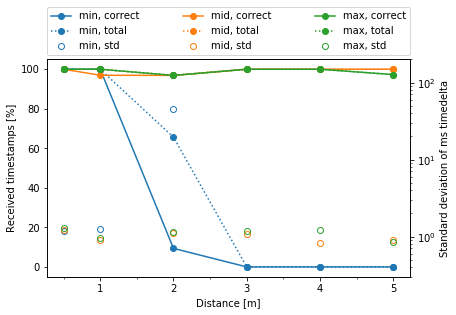

In [10]:
current_setup = 'corridor_lamp + 10mA IR_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)

fig = plt.figure(figsize=small_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.5))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_indoors_10mA.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_indoors_10mA.png', bbox_inches='tight', dpi=300, transparent=True)


plt.show()

### corridor_lamp + 50mA IR retake_0.0

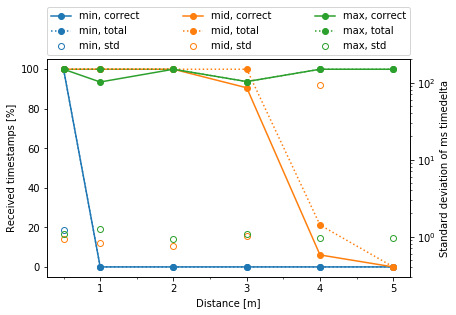

In [11]:
current_setup = 'corridor_lamp + 50mA IR retake_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)

plt.figure(figsize=small_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.5))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_indoors_50mA.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_indoors_50mA.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### outdoors_night_0.0

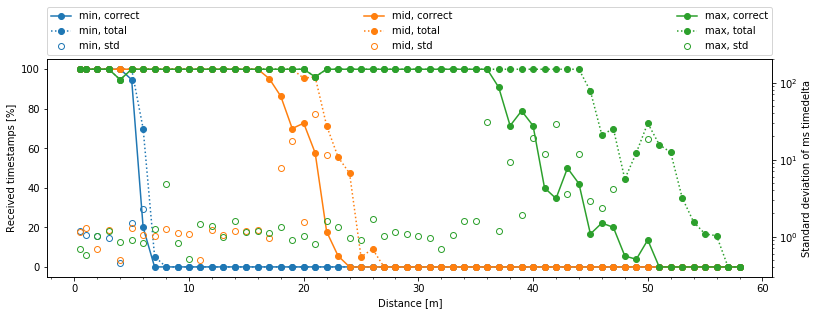

In [12]:
current_setup = 'outdoors_night_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)
results = results.append({'distance':57, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)
results = results.append({'distance':58, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)

plt.figure(figsize=large_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_outdoors_night.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_outdoors_night.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### outdoors_rx shade_0.0

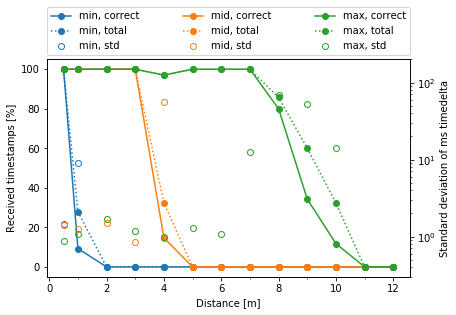

In [13]:
current_setup = 'outdoors_rx shade_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)
results = results.append({'distance':11, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)
results = results.append({'distance':12, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)

plt.figure(figsize=small_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_outdoors_rx_shade.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_outdoors_rx_shade.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### outdoors_shade_0.0

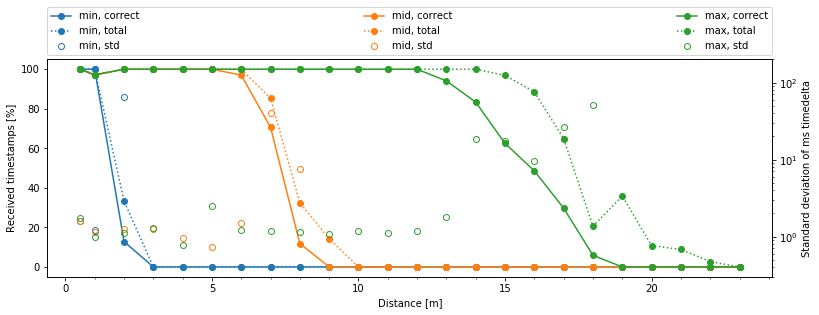

In [14]:
current_setup = 'outdoors_shade_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)
results = results.append({'distance':23, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)

plt.figure(figsize=large_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_outdoors_shade.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_outdoors_shade.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### outdoors_sunshine direct rx_0.0

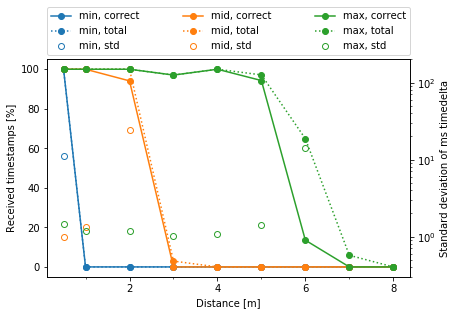

In [15]:
current_setup = 'outdoors_sunshine direct rx_0.0'
results = all_results[all_results['setup'] == current_setup]
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results.sort_values(by=['distance'], inplace=True)
results_diff.sort_values(by=['distance'], inplace=True)
results = results.append({'distance':8, 'total':1, 'min_total':0, 'min_correct':0, 'mid_total':0, 'mid_correct':0, 'max_total':0, 'max_correct':0}, ignore_index=True)

plt.figure(figsize=small_figsize)
plt.plot(results['distance'], results['min_correct'] / results['total'] * 100, 'o-C0', label='min, correct')
plt.plot(results['distance'], results['min_total']   / results['total'] * 100, 'o:C0', label='min, total')
plt.plot(results['distance'], results['mid_correct'] / results['total'] * 100, 'o-C1', label='mid, correct')
plt.plot(results['distance'], results['mid_total']   / results['total'] * 100, 'o:C1', label='mid, total')
plt.plot(results['distance'], results['max_correct'] / results['total'] * 100, 'o-C2', label='max, correct')
plt.plot(results['distance'], results['max_total']   / results['total'] * 100, 'o:C2', label='max, total')
ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Received timestamps [%]')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax2 = ax.twinx()
ax2.plot(results_diff['distance'], results_diff['diff_min_std'], 'oC0', linestyle='none', fillstyle='none', label='min, std')
ax2.plot(results_diff['distance'], results_diff['diff_mid_std'], 'oC1', linestyle='none', fillstyle='none', label='mid, std')
ax2.plot(results_diff['distance'], results_diff['diff_max_std'], 'oC2', linestyle='none', fillstyle='none', label='max, std')

ax2.set_ylabel('Standard deviation of ms timedelta')
ax2.set_yscale("log")
ax2.set_ylim(0.3,200)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

all_lines = lines[0:2] + [lines2[0]] + lines[2:4] + [lines2[1]] + lines[4:6] + [lines2[2]]
all_labels = labels[0:2] + [labels2[0]] + labels[2:4] + [labels2[1]] + labels[4:6] + [labels2[2]]
legend = ax.legend(all_lines, all_labels, bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)

# plt.savefig('rx_graphs/rx_outdoors_sunshine.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_outdoors_sunshine.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

## All correct

In the following test setups all timestamps were received correctly.

### corridor_lamp_180.0

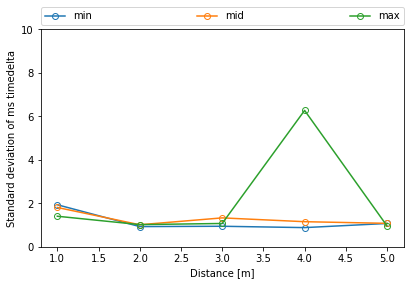

In [16]:
current_setup = 'corridor_lamp_0.0'
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results_diff.sort_values(by=['distance'], inplace=True)

plt.figure(figsize=small_figsize)

plt.plot(results_diff['distance'], results_diff['diff_min_std'], 'o-C0', fillstyle='none', label='min')
plt.plot(results_diff['distance'], results_diff['diff_mid_std'], 'o-C1', fillstyle='none', label='mid')
plt.plot(results_diff['distance'], results_diff['diff_max_std'], 'o-C2', fillstyle='none', label='max')

ax = plt.gca()
legend = ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Standard deviation of ms timedelta')

ax.set_ylim(0,10)

# plt.savefig('rx_graphs/rx_indoors_std_0.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_indoors_std_0.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### corridor_lamp_90.0

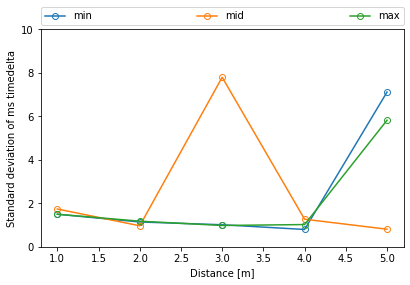

In [17]:
current_setup = 'corridor_lamp_90.0'
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results_diff.sort_values(by=['distance'], inplace=True)

plt.figure(figsize=small_figsize)

plt.plot(results_diff['distance'], results_diff['diff_min_std'], 'o-C0', fillstyle='none', label='min')
plt.plot(results_diff['distance'], results_diff['diff_mid_std'], 'o-C1', fillstyle='none', label='mid')
plt.plot(results_diff['distance'], results_diff['diff_max_std'], 'o-C2', fillstyle='none', label='max')

ax = plt.gca()
legend = ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Standard deviation of ms timedelta')

ax.set_ylim(0,10)

# plt.savefig('rx_graphs/rx_indoors_std_90.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_indoors_std_90.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### corridor_lamp_180.0

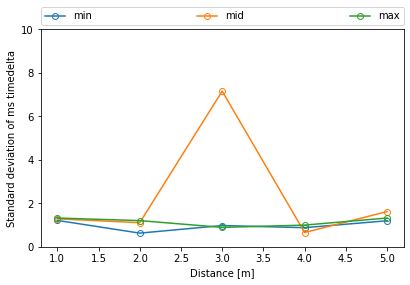

In [18]:
current_setup = 'corridor_lamp_180.0'
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results_diff.sort_values(by=['distance'], inplace=True)

plt.figure(figsize=small_figsize)

plt.plot(results_diff['distance'], results_diff['diff_min_std'], 'o-C0', fillstyle='none', label='min')
plt.plot(results_diff['distance'], results_diff['diff_mid_std'], 'o-C1', fillstyle='none', label='mid')
plt.plot(results_diff['distance'], results_diff['diff_max_std'], 'o-C2', fillstyle='none', label='max')

ax = plt.gca()
legend = ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Standard deviation of ms timedelta')

ax.set_ylim(0,10)

# plt.savefig('rx_graphs/rx_indoors_std_180.pdf', bbox_inches='tight', dpi=300)

# change colors

# axes_color = '#40c6cc'
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# ax = plt.gca()
# ax.spines['bottom'].set_color(axes_color)
# ax.spines['top'].set_color(axes_color)
# ax.spines['left'].set_color(axes_color)
# ax.spines['right'].set_color(axes_color)
# ax.xaxis.label.set_color(axes_color)
# ax.tick_params(axis='x', colors=axes_color, which='both')
# ax.yaxis.label.set_color(axes_color)
# ax.tick_params(axis='y', colors=axes_color, which='both')
# ax.title.set_color(axes_color)
# plt.setp(legend.get_texts(), color=axes_color)
# legend.get_frame().set_edgecolor(axes_color)
# legend.get_frame().set_facecolor('none')

# plt.savefig('rx_graphs/rx_indoors_std_180.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### indoors_daylight_pendulum

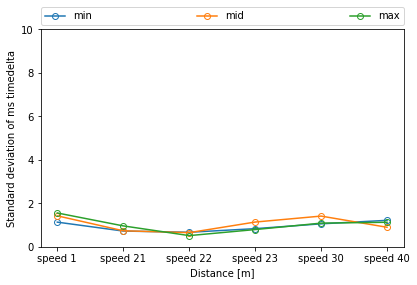

In [19]:
current_setup = 'indoors_daylight_pendulum'
results_diff = all_results_diff[all_results_diff['setup'] == current_setup]
results_diff.sort_values(by=['distance'], inplace=True)

plt.figure(figsize=small_figsize)

plt.plot(results_diff['distance'], results_diff['diff_min_std'], 'o-C0', fillstyle='none', label='min')
plt.plot(results_diff['distance'], results_diff['diff_mid_std'], 'o-C1', fillstyle='none', label='mid')
plt.plot(results_diff['distance'], results_diff['diff_max_std'], 'o-C2', fillstyle='none', label='max')

ax = plt.gca()
ax.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left',ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Standard deviation of ms timedelta')

ax.set_ylim(0,10)

# plt.savefig('rx_graphs/rx_outdoors_sunshine.pdf', bbox_inches='tight', dpi=300)

plt.show()